# **Problem Statement:**
In this problem, you'll train a CNN model to classify whether images contain either a dog or a cat. This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.
The Dogs vs. Cats dataset is a standard computer vision dataset that involves classifying photos as either containing a dog or cat.

# **Import Libraries**

In [48]:
import numpy as np
import pandas as pd
import os
import zipfile
import shutil
from tqdm import tqdm
import random

# plots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from tensorflow.keras.utils import plot_model

# preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img, array_to_img

# model
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, InceptionV3, VGG16, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint

# metric
from sklearn.metrics import classification_report 

# Settings the warnings to be ignored
from warnings import filterwarnings
filterwarnings("ignore")

# **Load And Extract Data**

In [2]:
def unzip_files(zip_files):
    for zip_file in zip_files:
        with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(zip_file), "r") as z:
            z.extractall(".")
            print(f"{zip_file} unzipped")

    TRAIN_DIR_PATH = './train'
    file_names = os.listdir(TRAIN_DIR_PATH)
    print('There are {} number of images in directory.'.format(len(file_names)))

zip_files = ["test1", "train"]
file_data = unzip_files(zip_files)
file_data

test1 unzipped
train unzipped
There are 25000 number of images in directory.


In [3]:
TRAIN_DIR_PATH = './train'
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 25000 number of images in directory.


In [4]:
def to_dataframe(file_names):
    files = []
    labels = []
    for file in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filename':files, 'label':labels})
    return df

df = to_dataframe(file_names)
df.head()

,filename,label
0,dog.7191.jpg,dog
1,cat.7853.jpg,cat
2,cat.4078.jpg,cat
3,dog.7229.jpg,dog
4,dog.1370.jpg,dog


# **EDA**

## **Data Set Label Distribution**

In [5]:
pd.DataFrame({
    "number": df["label"].value_counts()
}).style.background_gradient(cmap="magma")

,number
label,
dog,12500
cat,12500


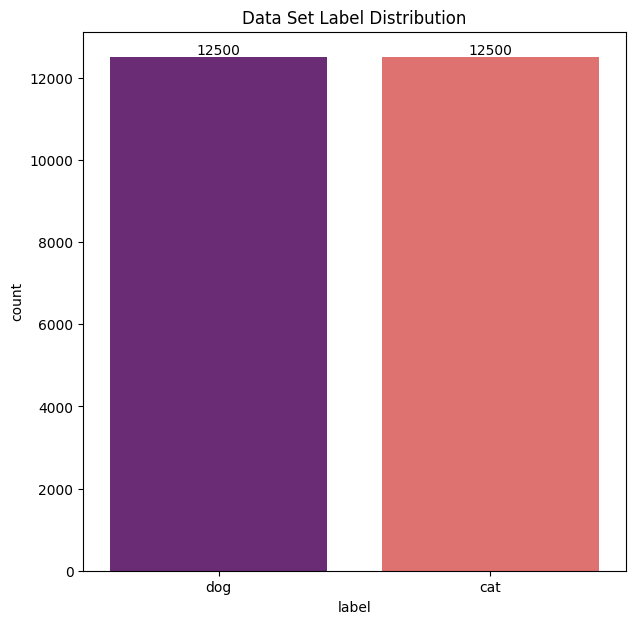

In [6]:
plt.figure(figsize=(7,7))
ax = sns.countplot(x = df["label"], palette="magma")
ax.bar_label(ax.containers[0])
plt.title("Data Set Label Distribution")
plt.show()

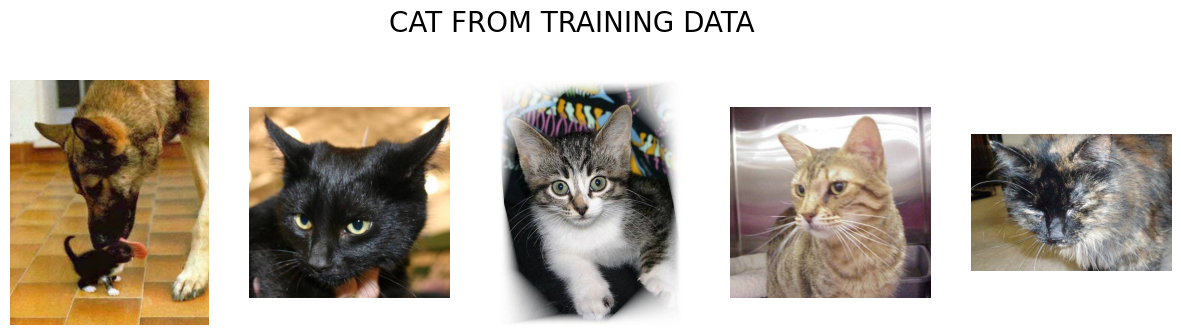

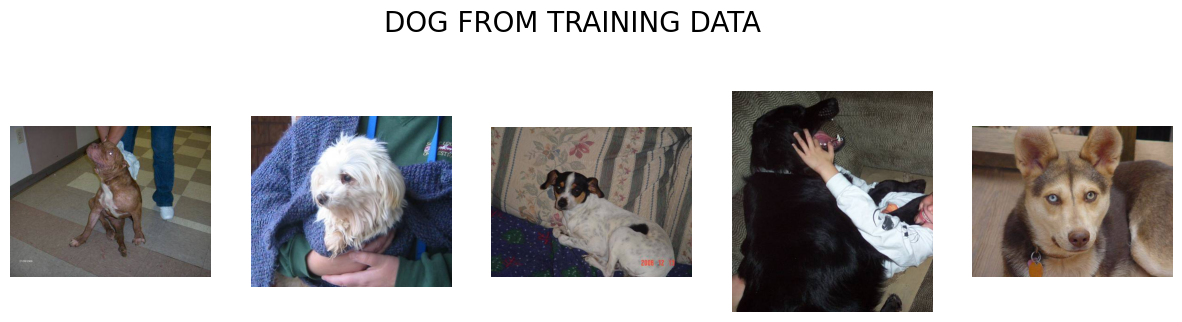

In [49]:
def display_random_images(images, path, title):
    plt.figure(figsize=(15, 7))
    plt.suptitle(title.upper(), size=20)
    for i, image_path in enumerate(np.random.choice(images, 5, replace=False), start=1):
        plt.subplot(2, 5, i)
        im = mpimg.imread(path + image_path)
        plt.imshow(im)
        plt.axis('off')

# فیلتر کردن نام فایل‌ها بر اساس شرط
cat = [file for file in file_names if file.startswith('cat')]
dog = [file for file in file_names if file.startswith('dog')]

display_random_images(cat, './train/', 'Cat From Training Data')
display_random_images(dog, './train/', 'Dog From Training Data')

plt.show()

**Looking at a few random photos in the directory, you can see that the photos are color and have different shapes and sizes.**

# **Preprocessing**

### **Rainy filter**

In [9]:
def add_rain_effect_to_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    image_files = [filename for filename in os.listdir(input_folder) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Randomly shuffle the list of image files
    random.shuffle(image_files)

    # Select half of the images
    selected_files = image_files[:len(image_files) // 2]
    
    for filename in tqdm(image_files, desc='Processing images'):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            imshape = image.shape
            slant_extreme = 10
            slant = np.random.randint(-slant_extreme, slant_extreme)
            drop_length = 10
            drop_width = 1
            drop_color = (180, 180, 180)

            for i in range(1500):
                if slant < 0:
                    x = np.random.randint(slant, imshape[1])
                else:
                    x = np.random.randint(0, imshape[1] - slant)
                y = np.random.randint(0, imshape[0] - drop_length)
                cv2.line(image, (x, y), (x + slant, y + drop_length), drop_color, drop_width)

            image = cv2.blur(image, (7, 7)) 

            brightness_coefficient = 0.7 
            image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)  
            image_HLS[:, :, 1] = image_HLS[:, :, 1] * brightness_coefficient
            
            image_RGB = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB) 

            base_name, ext = os.path.splitext(filename)
            new_filename = f"{base_name}_rain{ext}"

            output_path = os.path.join(output_folder, new_filename)
            cv2.imwrite(output_path, image_RGB)

# The path of the main images folder
input_image_folder = './train'
# Path for storing images under the rain effect
output_image_folder = './output_images_rainy'

add_rain_effect_to_images(input_image_folder, output_image_folder)

Processing images: 100%|██████████| 25000/25000 [13:40<00:00, 30.47it/s]


### **Snow Filter**

In [10]:
def add_snow_effect_to_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [filename for filename in os.listdir(input_folder) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Randomly shuffle the list of image files
    random.shuffle(image_files)

    # Select half of the images
    selected_files = image_files[:len(image_files) // 2]
    
    for filename in tqdm(image_files, desc='Processing images'):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            image_HLS = np.array(image_HLS, dtype=np.float64)

            brightness_coefficient = 2.5
            snow_point = 140

            image_HLS[:, :, 1][image_HLS[:, :, 1] < snow_point] *= brightness_coefficient
            image_HLS[:, :, 1][image_HLS[:, :, 1] > 255] = 255

            image_HLS = np.array(image_HLS, dtype=np.uint8)
            image_RGB = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)

            base_name, ext = os.path.splitext(filename)
            new_filename = f"{base_name}_snow{ext}"

            output_path = os.path.join(output_folder, new_filename)
            cv2.imwrite(output_path, image_RGB)

# Path to the original image folder
input_image_folder = './train'
# Path for storing images under the snow effect
output_image_folder = './output_images_snowy'

add_snow_effect_to_images(input_image_folder, output_image_folder)


Processing images: 100%|██████████| 25000/25000 [04:17<00:00, 97.09it/s] 


### **Fog Filter**

In [11]:
def add_fog_to_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    image_files = [filename for filename in os.listdir(input_folder) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Randomly shuffle the list of image files
    random.shuffle(image_files)

    # Select half of the images
    selected_files = image_files[:len(image_files) // 2]

    for filename in tqdm(selected_files, desc='Processing images'):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image = cv2.imread(image_path)

            fog_intensity = 0.65  # Intensity of the fog effect, you can adjust this value

            # Create a fog layer
            fog = np.ones_like(image) * 255
            fog = fog * fog_intensity
            fog = fog.astype(image.dtype)  # Convert fog to the same data type as image

            # Merge the fog layer with the original image
            blended = cv2.addWeighted(image, 1 - fog_intensity, fog, fog_intensity, 0)

            base_name, ext = os.path.splitext(filename)
            new_filename = f"{base_name}_foggy{ext}"

            output_path = os.path.join(output_folder, new_filename)
            cv2.imwrite(output_path, blended)

# Path to the original image folder
input_image_folder = './train'
# Path for storing images under the fog effect
output_image_folder = './output_images_foggy'

add_fog_to_images(input_image_folder, output_image_folder)

Processing images: 100%|██████████| 12500/12500 [01:20<00:00, 155.60it/s]


### **Merge Folder**

In [12]:
def merge_directories(source_directories, destination_directory):
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    total_files = sum(len(files) for source_dir in source_directories for _, _, files in os.walk(source_dir))
    progress = tqdm(total=total_files, desc='Merging images')

    for source_dir in source_directories:
        for root, _, files in os.walk(source_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    source_path = os.path.join(root, file)
                    destination_path = os.path.join(destination_directory, file)
                    try:
                        shutil.copy(source_path, destination_path)
                        progress.update(1)
                    except Exception as e:
                        print(f"Error: {e} - Skipping {file}")

    progress.close()

# Paths for image directories
rain_images_folder = './output_images_rainy'
snow_images_folder = './output_images_snowy'
fog_images_folder = './output_images_foggy'

# Destination folder to merge all images
combined_images_folder = './combined_image'

source_directories = [rain_images_folder, snow_images_folder, fog_images_folder]

merge_directories(source_directories, combined_images_folder)

Merging images: 100%|██████████| 62500/62500 [00:09<00:00, 6718.39it/s]


In [13]:
path_combined_image = "./combined_image"
filter_image_path = os.listdir(path_combined_image)

print('There are {} number of images in directory.'.format(len(filter_image_path)))

df_combined_image = to_dataframe(filter_image_path)
df_combined_image

There are 62500 number of images in directory.


,filename,label
0,cat.3332_rain.jpg,cat
1,cat.6050_rain.jpg,cat
2,cat.11023_foggy.jpg,cat
3,cat.11848_foggy.jpg,cat
4,dog.393_rain.jpg,dog
...,...,...
62495,cat.11752_foggy.jpg,cat
62496,dog.9402_snow.jpg,dog
62497,cat.9685_foggy.jpg,cat
62498,cat.6335_rain.jpg,cat


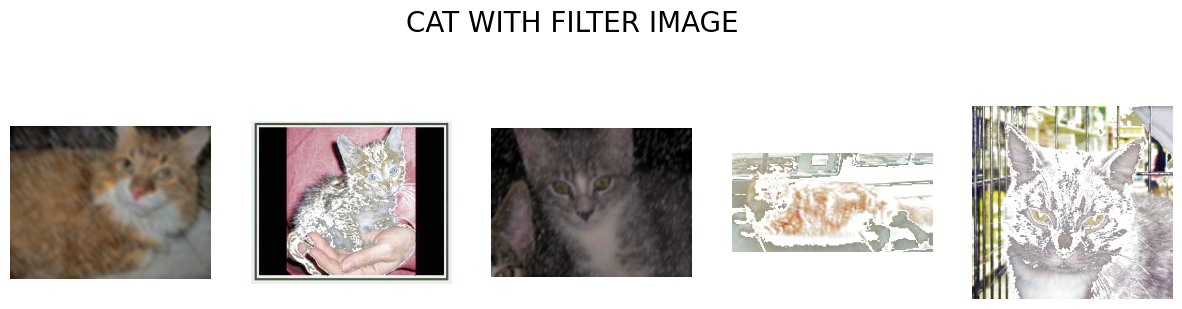

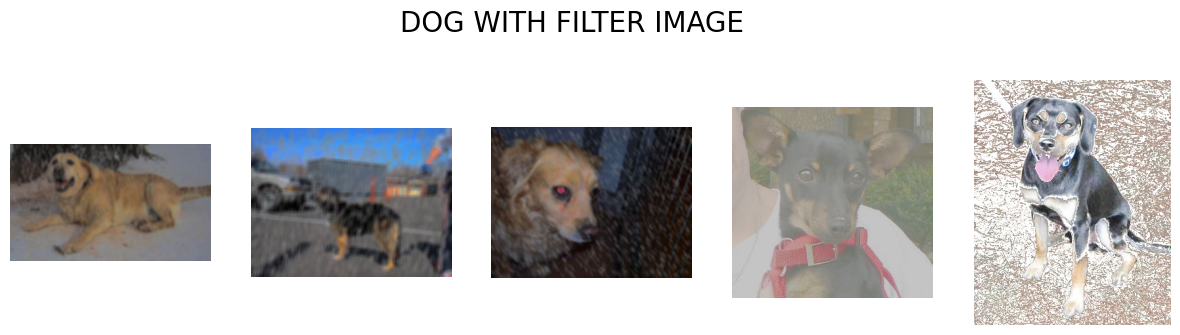

In [50]:
cat_filter = [file for file in filter_image_path if file.startswith('cat')]
dog_filter = [file for file in filter_image_path if file.startswith('dog')]

display_random_images(cat_filter, "./combined_image/", "Cat With Filter Image")
display_random_images(dog_filter, "./combined_image/", "Dog With Filter Image")

## **Split Data**

In [15]:
train_set, test_set = train_test_split(df_combined_image, test_size=0.2, random_state=0)

In [16]:
train_set.shape, test_set.shape

((50000, 2), (12500, 2))

Train Set Label Distribution:
 label
cat    25076
dog    24924
Name: count, dtype: int64

Test Set Label Distribution:
 label
dog    6293
cat    6207
Name: count, dtype: int64



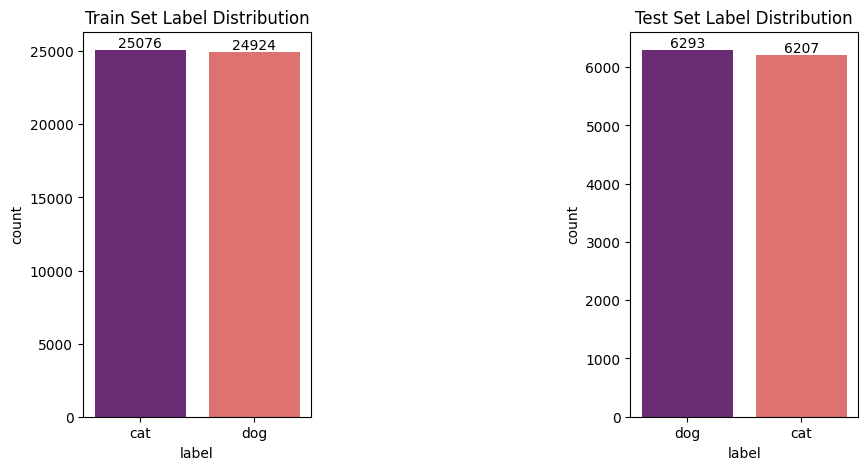

In [17]:
print('Train Set Label Distribution:\n', train_set["label"].value_counts())
print('\nTest Set Label Distribution:\n', test_set["label"].value_counts())
print()

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
ax = sns.countplot(x=train_set["label"], palette="magma")
ax.bar_label(ax.containers[0])
plt.title("Train Set Label Distribution")

plt.subplot(1,3,3)
ax = sns.countplot(x=test_set["label"], palette="magma")
ax.bar_label(ax.containers[0])
plt.title("Test Set Label Distribution")
plt.show()

# **Functions**

## **Create Function Data Augmentation And Transfer Learning**

In [18]:
def train_image_classification_model(
    df_train,
    base_model_name="ResNet50",
    width=224,
    height=224,
    batch_size=32,
    epochs=20,
    name_model_best_model="InceptionV3"
):

    # ---------Map model names to the actual Keras model functions---------
    models = {
        "ResNet50": ResNet50,
        "ResNet101": ResNet101,
        "VGG16": VGG16,
        "InceptionV3": InceptionV3,
        "DenseNet121": DenseNet121,
    }

    # ----------Split the data into train and test sets-------
    train_set, test_set = train_test_split(df_train, test_size=0.2, random_state=0)

    # ----------Create the image generators---------
    image_generator_train = ImageDataGenerator(rescale=1.0 / 255.0)
    
    train_df = image_generator_train.flow_from_dataframe(
        dataframe=train_set,
        directory="./combined_image",
        x_col="filename",
        y_col="label",
        target_size=(width, height),
        class_mode="binary",
        batch_size=batch_size,
        seed=42,
    )
    
    image_generator_test = ImageDataGenerator(rescale=1.0 / 255.0)
    
    test_df = image_generator_test.flow_from_dataframe(
        dataframe=test_set,
        directory="./combined_image",
        x_col="filename",
        y_col="label",
        target_size=(width, height),
        class_mode="binary",
        batch_size=batch_size,
        seed=42,
    )

    # -------Load the pre-trained model----------
    base_model = models[base_model_name](weights='imagenet', input_shape=(width, height, 3), include_top=False)
    base_model.trainable = False

    # -----------Create the model----------
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1024, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5)),
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # -----------Compile the model---------
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    
    # -----------Callbacks------------
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
    model_checkpoint = ModelCheckpoint(f"./best_model/{name_model_best_model}.h5", save_best_only=True)

    # -----------Train the model----------
    history = model.fit(
        train_df,
        steps_per_epoch=len(train_df),
        epochs=epochs,
        validation_data=test_df,
        validation_steps=len(test_df),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
    )

    # -----------Evaluate the model---------
    loss, accuracy = model.evaluate(image_generator_test.flow_from_dataframe(
        dataframe=test_set,
        directory="./combined_image",
        x_col="filename",
        y_col="label",
        target_size=(width, height),
        class_mode="binary",
        batch_size=batch_size,
        seed=42,
    ))

    print(f"Validation accuracy: {accuracy}")

    return model, history


## **Evaluation Function**

In [19]:
def evaluate_model(model, history, test_data):
    hist_df = pd.DataFrame(history.history)
    hist_df["epoch"] = history.epoch
    hist_df = hist_df.sort_values(by="val_accuracy", ascending=False)

    loss, accuracy = model.evaluate(test_data)
    print(f'Validation accuracy: {accuracy}')

    return hist_df, loss, accuracy

## **Create Function Plot Traning History**

In [20]:
def plot_training_history(history):
    plt.figure(figsize=(15,5))
    
    # Plotting accuracy
    plt.subplot(1,2,1)
    plt.plot(history["epoch"], history["accuracy"], "bo", label="Training accuracy")
    plt.plot(history["epoch"], history["val_accuracy"], "b", label="Validation accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1,2,2)
    plt.plot(history["epoch"], history["loss"], 'go', label='Training Loss')
    plt.plot(history["epoch"], history["val_loss"], 'g', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# **Create function prediction**

In [41]:
def load_model(name_model):
    best_model = tf.keras.models.load_model(f"./best_model/{name_model}.h5")
    
    return best_model

In [52]:
def show_random_test_images_with_predictions(model, test_directory, num_images_to_show):
    image_files = [filename for filename in os.listdir(test_directory) if filename.endswith(('.jpg', '.jpeg', '.png'))]

    selected_images = random.sample(image_files, num_images_to_show)

    plt.figure(figsize=(15, 10))
    
    for i, filename in enumerate(selected_images, start=1):
        plt.subplot(3, num_images_to_show, i)
        img_path = os.path.join(test_directory, filename)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array)
        predicted_class = "Dog" if prediction > 0.5 else "Cat"

        plt.title(predicted_class)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## **Resnet152**

### **Run Model**

In [67]:
trained_model_resnet101, history_resnet101 = train_image_classification_model(
    df_combined_image,
    base_model_name="ResNet101",
    width=224,
    height=224,
    batch_size=100,
    epochs=10,
    name_model_best_model="ResNet101"
)

Found 50000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 351s 684ms/step - loss: 0.6962 - accuracy: 0.5416 - val_loss: 0.6865 - val_accuracy: 0.5157 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 342s 684ms/step - loss: 0.6759 - accuracy: 0.5696 - val_loss: 0.6638 - val_accuracy: 0.5861 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 342s 684ms/step - loss: 0.6672 - accuracy: 0.5814 - val_loss: 0.6557 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 341s 682ms/step - loss: 0.6630 - accuracy: 0.5906 - val_loss: 0.6560 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 341s 681ms/step - loss: 0.6560 - accuracy: 0.6053 - val_loss: 0.6557 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 343s 685ms/step - loss: 0.6

### **Evaluation**

In [68]:
hist_df_resnet101 = evaluate_model(history_resnet101)

### **Plot The Training History**

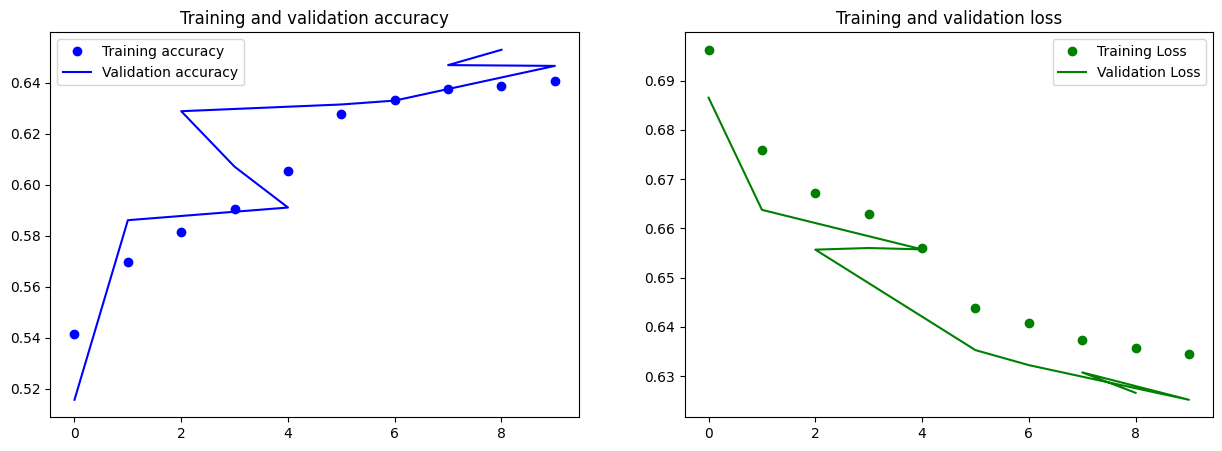

In [69]:
plot_training_history(hist_df_resnet101)

### **Perdiction**

1/1 [==============================] - 0s 26ms/step


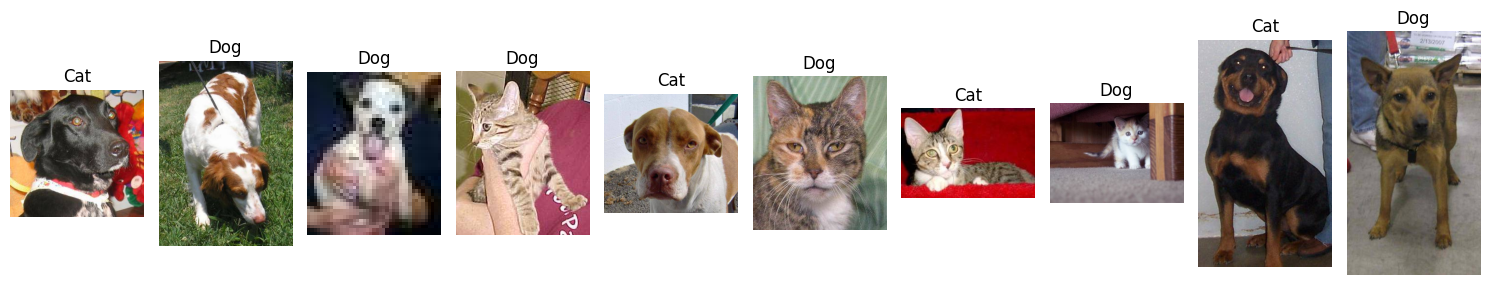

In [70]:
# Loading the best model
resnet101_model = load_model("ResNet101")

# Test directory
test_image_directory = './test1'

# Number of random images to display
num_random_images = 10

# Displaying random test images along with predictions
show_random_test_images_with_predictions(resnet101_model, test_image_directory, num_random_images)

## **InceptionV3**

### **Run Model**

In [40]:
trained_model_inception, history_inception = train_image_classification_model(
    df_combined_image,
    base_model_name="InceptionV3",
    width=224,
    height=224,
    batch_size=100,
    epochs=10,
    name_model_best_model="InceptionV3"
)

Found 50000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 189s 369ms/step - loss: 0.1860 - accuracy: 0.9219 - val_loss: 0.1533 - val_accuracy: 0.9324 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 182s 364ms/step - loss: 0.1491 - accuracy: 0.9359 - val_loss: 0.1407 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 181s 362ms/step - loss: 0.1433 - accuracy: 0.9376 - val_loss: 0.1288 - val_accuracy: 0.9423 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 183s 365ms/step - loss: 0.1384 - accuracy: 0.9390 - val_loss: 0.1257 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 181s 361ms/step - loss: 0.1340 - accuracy: 0.9420 - val_loss: 0.1337 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 183s 365ms/step - loss: 0.1

### **Evaluation**

In [44]:
hist_df_inception = evaluate_model(history_inception)
hist_df_inception

,loss,accuracy,val_loss,val_accuracy,lr,epoch
9,0.102155,0.95672,0.118614,0.94808,0.0002,9
7,0.108958,0.95390,0.121143,0.94800,0.0002,7
8,0.104954,0.95528,0.117823,0.94712,0.0002,8
6,0.114144,0.95148,0.119250,0.94592,0.0002,6
3,0.138415,0.93896,0.125726,0.94408,0.0010,3
4,0.133994,0.94200,0.133708,0.94288,0.0010,4
2,0.143309,0.93756,0.128831,0.94232,0.0010,2
1,0.149102,0.93592,0.140733,0.93544,0.0010,1
5,0.131809,0.94334,0.144187,0.93464,0.0010,5
0,0.185973,0.92186,0.153272,0.93240,0.0010,0


### **Plot The Training History**

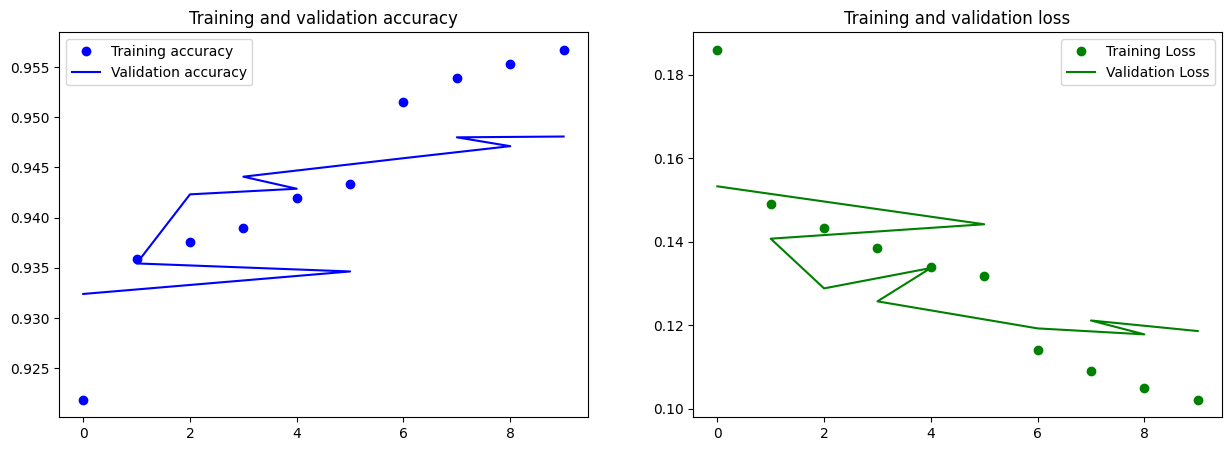

In [45]:
plot_training_history(hist_df_inception)

### **Perdiction**

1/1 [==============================] - 0s 25ms/step


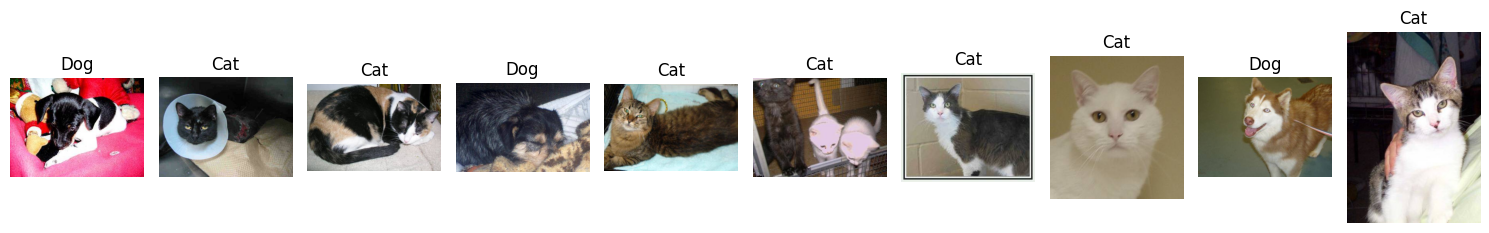

In [53]:
# Loading the best model
inception_model = load_model("InceptionV3")

# Test directory
test_image_directory = './test1'

# Number of random images to display
num_random_images = 10

# Displaying random test images along with predictions
show_random_test_images_with_predictions(inception_model, test_image_directory, num_random_images)

## **VGG16**

### **Run Model**

In [54]:
trained_model_vgg16, history_vgg16 = train_image_classification_model(
    df_combined_image,
    base_model_name="VGG16",
    width=224,
    height=224,
    batch_size=100,
    epochs=10,
    name_model_best_model="VGG16"
)

Found 50000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 291s 577ms/step - loss: 0.4955 - accuracy: 0.7438 - val_loss: 0.4180 - val_accuracy: 0.8101 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 287s 574ms/step - loss: 0.4276 - accuracy: 0.7941 - val_loss: 0.4007 - val_accuracy: 0.8117 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 287s 574ms/step - loss: 0.4081 - accuracy: 0.8060 - val_loss: 0.3888 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 287s 573ms/step - loss: 0.3988 - accuracy: 0.8108 - val_loss: 0.3795 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 287s 573ms/step - loss: 0.3900 - accuracy: 0.8169 - val_loss: 0.4264 - val_accuracy: 0.7902 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 287s 574ms/step - loss: 0.3

### **Evaluation**

In [55]:
hist_df_vgg16 = evaluate_model(history_vgg16)

### **Plot The Training History**

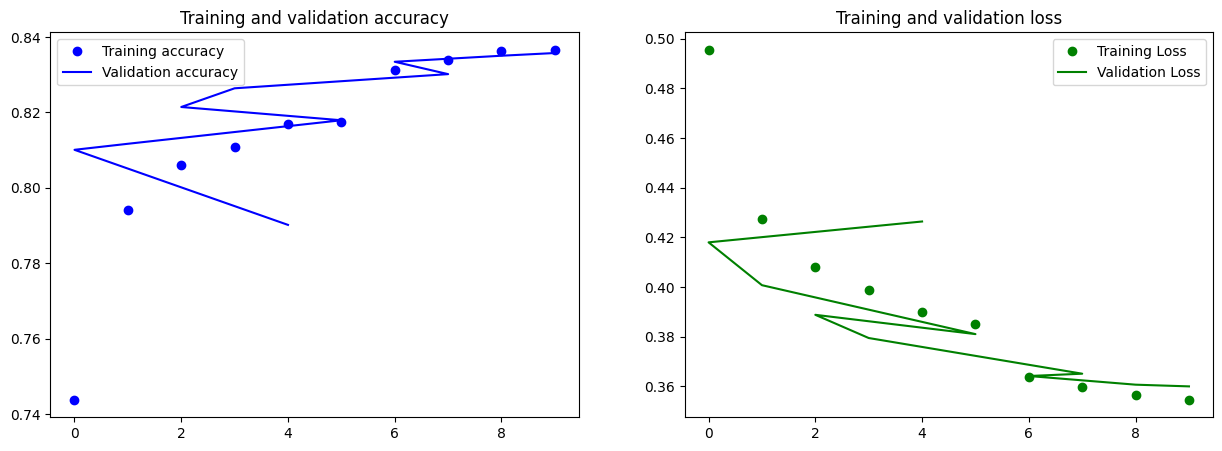

In [56]:
plot_training_history(hist_df_vgg16)

### **Perdiction**

1/1 [==============================] - 0s 18ms/step


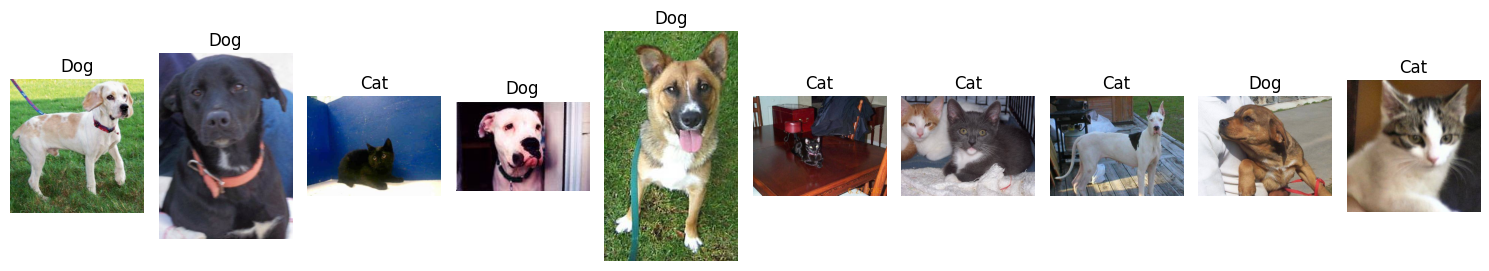

In [57]:
# Loading the best model
vgg16_model = load_model("VGG16")

# Test directory
test_image_directory = './test1'

# Number of random images to display
num_random_images = 10

# Displaying random test images along with predictions
show_random_test_images_with_predictions(vgg16_model, test_image_directory, num_random_images)

## **DenseNet121**

### **Run Model**

In [60]:
trained_model_densenet121, history_densenet121 = train_image_classification_model(
    df_combined_image,
    base_model_name="DenseNet121",
    width=224,
    height=224,
    batch_size=100,
    epochs=10,
    name_model_best_model="DenseNet121"
)

Found 50000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 197s 382ms/step - loss: 0.2113 - accuracy: 0.9058 - val_loss: 0.1518 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 189s 377ms/step - loss: 0.1675 - accuracy: 0.9258 - val_loss: 0.1422 - val_accuracy: 0.9368 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 189s 377ms/step - loss: 0.1590 - accuracy: 0.9307 - val_loss: 0.1590 - val_accuracy: 0.9315 - lr: 0.0010
Epoch 4/10
500/500 [==============================] - 188s 376ms/step - loss: 0.1527 - accuracy: 0.9335 - val_loss: 0.1332 - val_accuracy: 0.9414 - lr: 0.0010
Epoch 5/10
500/500 [==============================] - 187s 374ms/step - loss: 0.1456 - accuracy: 0.9367 - val_loss: 0.1400 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 6/10
500/500 [==============================] - 188s 377ms/step - loss: 0.1

### **Evaluation**

In [64]:
hist_df_densenet121 = evaluate_model(history_densenet121)
hist_df_densenet121

,loss,accuracy,val_loss,val_accuracy,lr,epoch
9,0.114447,0.95166,0.125162,0.94728,0.0002,9
5,0.143018,0.93776,0.131786,0.94320,0.0010,5
6,0.139967,0.93944,0.129595,0.94224,0.0010,6
7,0.136083,0.94034,0.130576,0.94192,0.0010,7
3,0.152690,0.93354,0.133193,0.94144,0.0010,3
8,0.131171,0.94310,0.130119,0.94104,0.0010,8
4,0.145618,0.93672,0.139991,0.93976,0.0010,4
1,0.167514,0.92580,0.142242,0.93680,0.0010,1
0,0.211272,0.90582,0.151824,0.93248,0.0010,0
2,0.159015,0.93070,0.158997,0.93152,0.0010,2


### **Plot The Training History**

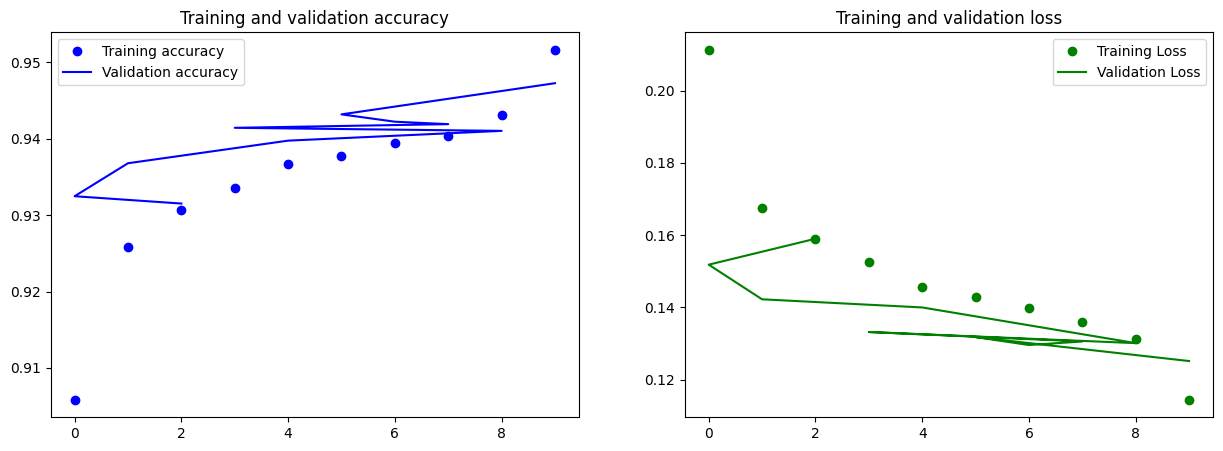

In [62]:
plot_training_history(hist_df_densenet121)

### **Perdiction**

1/1 [==============================] - 0s 29ms/step


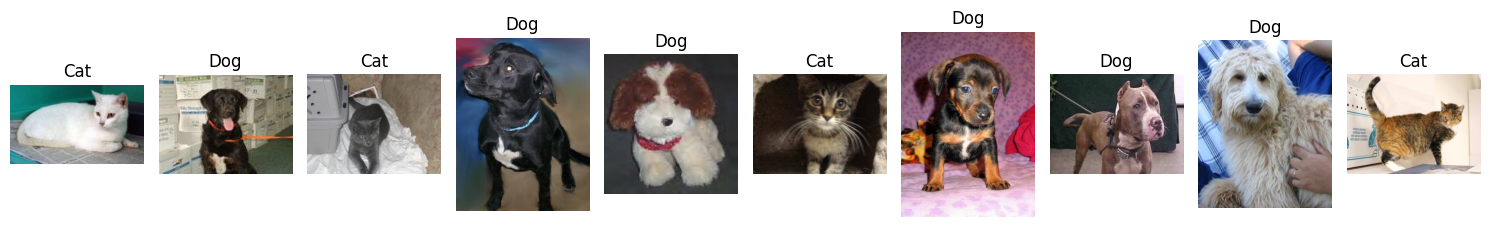

In [63]:
# Loading the best model
densenet121_model = load_model("DenseNet121")

# Test directory
test_image_directory = './test1'

# Number of random images to display
num_random_images = 10

# Displaying random test images along with predictions
show_random_test_images_with_predictions(densenet121_model, test_image_directory, num_random_images)

In [71]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

download_file('/kaggle/working/best_model/VGG16.h5', 'out')

/kaggle/working/out.zip